### Primary Hypothesis

When training on distinct chunks, OSFT maintains a much better balance of prior information retained while it learns new knowledge. Compared to SFT, OSFT should be able to:
* Retain prior custom knowledge as training progresses
* Maintains a better overall performance on general capabilities (leaderboard) 

**Hypothesis scenario:**
- OSFT on each distinct chunk

**Baseline scenarios**:
- Full SFT on the entire dataset (may reuse the results from experiment 1)
- Full OSFT on the entire dataset (may reuse the results from experiment 1)
- Full SFT on each distinct chunk

**Expected outcome**:
- For the % of knowledge gained on each custom domain, the % retained on existing domains should be far less than the baselines


### Secondary Hypothesis

Model subspace becomes saturated with the incoming datasets, so the rank ratio should be gradually reduced as we continue training.

**Hypothesis scenario**:
* OSFT on each distinct chunk, lowering rank ratio by some amount each time

**Comparative baselines**:
- OSFT on each distinct chunk, no change in rank ratio

**Expected outcome**:
* The _final_ checkpoint should have retained more information on each overall domain compared to the baseline

### Dataset

The dataset we'll be using is a version of the original training dataset used for experiment 1 (the quality dataset created using the new knowledge pipeline). 

Experiment 1 focused on chunking the datasets through simple uniform sampling. We will instead create the chunks by selecting samples out based on their documents.

**Chunking**:

We will use this simple chunking script:

```python
from datasets import load_dataset, Dataset
fp = "/mnt/nvme1n1/experiments/os-cl-scenario-1-experiment-0/synth_knowledge2_0-combined_cut_50x/combined_cut_50x.jsonl"
ds = load_dataset('json', data_files=fp, split="train")
all_docs = list(set(ds['document_outline']))

# Split into n equal parts
n = 3  # Change this to desired number of parts
total_docs = len(all_docs)
part_size = total_docs // n

# Create n parts dynamically
doc_parts = []
for i in range(n):
    start_idx = i * part_size
    end_idx = (i + 1) * part_size if i < n - 1 else total_docs  # Last part gets remaining docs
    doc_parts.append(ds.filter(lambda x: x['document_outline'] in all_docs[start_idx:end_idx]))

print(f"Total documents: {total_docs}")
for i, part in enumerate(doc_parts):
    print(f"Part {i+1}: {len(part)} documents")
```
### Evaluation

We will evaluate the model on: 
1. Domain knowledge (QuaLITY)
	1. Current chunk: only the documents from the current distribution
	2. Prior chunks: all prior documents seen, one-by-one
	3. Overall seen: every document seen so far
	4. Overall: Default eval set
2. General performance (Leaderboard)

#### Domain-Knowledge Segmentation

Since all chunks are disjoint subsets, we need an eval set for each respective chunk. Using Abhishek's code to split up the dataset into chunks, I've implemented a script to also create an eval dataset for each chunk.

The only issue is that the training dataset we use does not cover 2 of the documents in the original quality dataset. To account for this, I simply make sure that each eval dataset has these as common samples.


### Model & Hyper-parameters 

**Model**: `meta-llama/Llama-3.1-8B-Instruct`
**Constant Hyper-parameters:**

| Name               | Value    |
| ------------------ | -------- |
| LR                 | 5e-6     |
| BS                 | 128      |
| epochs             | 1        |
| LR scheduler       | constant |
| warmup steps       | 0        |
| max rank ratio<br> | 0.35     |

**Baselines to run**:
1. OSFT completed baseline (full, unchunked dataset, set to the max rank ratio)
2. OSFT chunked baseline (train in chunks, but keep the rank ratio the same each time)
3. SFT complete baseline (we just run a training run with these settings)
4. SFT chunked baseline (same SFT hyperparams, but train on the chunks)

**Hypothesis to run**:
1. OSFT experimental (train on each chunk, start from max rank ratio but reduce the rank ratio by 0.10 each time, so 0.35, 0.25, 0.15)

**Absolute QuaLITY Scores**: 

This table captures the **absolute** score on the QuaLITY evaluation per checkpoint. They are called "Absolute", because each chunked checkpoint (aside from the final chunk) is partially evaluated on entirely unseen data. 

| Experiment                                  | Attempt Rate | Accuracy Among Attempted | Overall Accuracy | Total Attempt Rate |
| :------------------------------------------ | -----------: | -----------------------: | ---------------: | -----------------: |
| **OSFT Decreasing RR - Chunk 0** (RR: 0.35) |            1 |                    0.441 |            0.441 |             0.9989 |
| **OSFT Decreasing RR - Chunk 1** (RR: 0.25) |            1 |                   0.4361 |           0.4361 |             0.9988 |
| **OSFT Decreasing RR - Chunk 2** (RR: 0.15) |            1 |                   0.4313 |           0.4313 |             0.9986 |
| **OSFT Constant RR - Chunk 0** (RR: 0.35)   |            1 |                   0.4072 |           0.4072 |             0.9988 |
| **OSFT Constant RR - Chunk 1** (RR: 0.35)   |            1 |                   0.4602 |           0.4602 |             0.9979 |
| **OSFT Constant RR - Chunk 2** (RR: 0.35)   |            1 |                    0.453 |            0.453 |             0.9983 |
| **OSFT Full Dataset** (RR: 0.35)            |            1 |                   0.4771 |           0.4771 |             0.9977 |
| **SFT Chunked - Chunk 0**                   |            1 |                   0.4289 |           0.4289 |              0.995 |
| **SFT Chunked - Chunk 1**                   |            1 |                   0.4892 |           0.4892 |             0.9907 |
| **SFT Chunked - Chunk 2**                   |            1 |                   0.5253 |           0.5253 |             0.9634 |
| **SFT Full Dataset**                        |            1 |                   0.5012 |           0.5012 |             0.9873 |

**Domain-specific QuaLITY scores**: 

Here we showcase the scores each checkpoint receives when evaluated on only the data that specific chunk was trained on. E.g., chunk 1 is only evaluated on the QuaLITY documents that chunk 1 trains on, chunk 2 only evaluates on QuaLITY documents that chunk 2 trains on, etc.

Here's the transformed table with human-readable experiment names for the chunk-specific QuaLITY evaluations:

| Experiment (Evaluated on Own Chunk)         | Attempt Rate | Accuracy Among Attempted | Overall Accuracy | Total Attempt Rate |
| :------------------------------------------ | -----------: | -----------------------: | ---------------: | -----------------: |
| **OSFT Decreasing RR - Chunk 0** (RR: 0.35) |            1 |                   0.5202 |           0.5202 |              0.999 |
| **OSFT Decreasing RR - Chunk 1** (RR: 0.25) |            1 |                   0.5000 |           0.5000 |             0.9986 |
| **OSFT Decreasing RR - Chunk 2** (RR: 0.15) |            1 |                   0.4449 |           0.4449 |             0.9974 |
| **OSFT Constant RR - Chunk 0** (RR: 0.35)   |            1 |                   0.5176 |           0.5176 |             0.9992 |
| **OSFT Constant RR- Chunk 1** (RR: 0.35)    |            1 |                   0.5026 |           0.5026 |             0.9983 |
| **OSFT Constant RR- Chunk 2** (RR: 0.35)    |            1 |                   0.4586 |           0.4586 |             0.9977 |
| **SFT Chunked - Chunk 0**                   |            1 |                   0.5319 |           0.5319 |             0.9963 |
| **SFT Chunked - Chunk 1**                   |            1 |                   0.5235 |           0.5235 |               0.99 |
| **SFT Chunked - Chunk 2**                   |            1 |                   0.5163 |           0.5163 |             0.9611 |
| **Base Model - Chunk 0**                    |       0.9974 |                   0.4458 |           0.4446 |             0.9831 |
| **Base Model - Chunk 1**                    |            1 |                   0.4360 |           0.4360 |             0.9832 |
| **Base Model - Chunk 2**                    |       0.9975 |                   0.4146 |           0.4135 |             0.9789 |


**Key observations:**
- **SFT performs best** on chunk-specific evaluations, with SFT Chunk 0 achieving the highest accuracy (53.19%)
- **OSFT Decreasing RR shows declining performance** as rank ratio decreases (52.02% → 50.00% → 44.49%)
- **OSFT Constant RR models** maintain relatively stable performance across chunks
- **Chunk-specific performance** is generally higher than the full dataset evaluations, suggesting models learn their training chunks well
- **SFT maintains consistent performance** across all chunks (51.63% - 53.19%), while OSFT shows more variation

**Progressive QuaLITY scores**:


This table captures how well each model performs on the subset of QuaLITY that it has been trained on overall. So the chunk 1 checkpoint is only evaluated on the QuaLITY subset for chunk 1, but the chunk 2 checkpoint gets evaluated on the QuaLITY subset of chunk 2 **and** chunk 1, and finally chunk 3 is evaluated on all of QuaLITY. 

| Experiment (Progressive Evaluation)                  | Attempt Rate | Accuracy Among Attempted | Overall Accuracy | Total Attempt Rate |
| ---------------------------------------------------- | ------------ | ------------------------ | ---------------- | ------------------ |
| Base Model - Chunk 0 Progressive                     | 0.9974       | 0.4405                   | 0.4394           | 0.9844             |
| Base Model - Chunk 1 Progressive                     | 0.9987       | 0.4316                   | 0.4310           | 0.9842             |
| Base Model - Chunk 2 Progressive                     | 0.9983       | 0.4313                   | 0.4305           | 0.9809             |
| OSFT Decreasing RR - Chunk 0 Progressive (RR: 0.35)  | 1.0000       | 0.5202                   | 0.5202           | 0.9989             |
| OSFT Decreasing RR - Chunk 1 Progressive (RR: 0.25)  | 1.0000       | 0.5083                   | 0.5083           | 0.9986             |
| OSFT Decreasing RR - Chunk 2 Progressive (RR: 0.15)  | 1.0000       | 0.4815                   | 0.4815           | 0.9979             |
| OSFT Constant RR - Chunk 0 Progressive (RR: 0.35)    | 1.0000       | 0.5202                   | 0.5202           | 0.9989             |
| OSFT Constant RR - Chunk 1 Progressive (RR: 0.35)    | 1.0000       | 0.5182                   | 0.5182           | 0.9989             |
| OSFT Constant RR - Chunk 2 Progressive (RR: 0.35)    | 1.0000       | 0.5020                   | 0.5020           | 0.9983             |
| OSFT Constant RR v2 - Chunk 0 Progressive (RR: 0.35) | 1.0000       | 0.5150                   | 0.5150           | 0.9991             |
| OSFT Constant RR v2 - Chunk 1 Progressive (RR: 0.35) | 1.0000       | 0.5116                   | 0.5116           | 0.9985             |
| OSFT Constant RR v2 - Chunk 2 Progressive (RR: 0.35) | 1.0000       | 0.4902                   | 0.4902           | 0.9980             |
| SFT Chunked - Chunk 0 Progressive                    | 1.0000       | 0.5398                   | 0.5398           | 0.9960             |
| SFT Chunked - Chunk 1 Progressive                    | 1.0000       | 0.5274                   | 0.5274           | 0.9905             |
| SFT Chunked - Chunk 2 Progressive                    | 1.0000       | 0.5290                   | 0.5290           | 0.9600             |

Key observations for Progressive Evaluation:

- SFT continues to outperform OSFT on progressive datasets, with SFT Chunk 0 achieving the highest accuracy (53.98%)

- OSFT Decreasing RR shows declining performance as rank ratio decreases: 52.02% → 50.83% → 48.15%

- Progressive datasets are more challenging than chunk-specific ones - compare to single-chunk results where models achieved higher scores

- Base model performance is consistent across progressive chunks (~43-44%), establishing a clear baseline

- All trained models significantly outperform the base model by 6-10 percentage points

- OSFT models maintain relatively stable performance across progressive evaluations, while SFT shows slight variation

**Leaderboard Scores**:

| Experiment/Checkpoint             | Overall |    BBH |   GPQA | IFEval | MATH-Hard | MMLU-Pro |   MUSR |
| :-------------------------------- | ------: | -----: | -----: | -----: | --------: | -------: | -----: |
| **OSFT Decreasing RR - Chunk 0**  |  42.49% | 50.21% | 29.90% | 77.37% |    17.24% |   37.97% | 42.25% |
| **OSFT Decreasing RR - Chunk 1**  |  41.26% | 49.22% | 30.74% | 74.72% |    14.44% |   36.98% | 41.46% |
| **OSFT Decreasing RR - Chunk 2**  |  40.90% | 49.37% | 29.94% | 73.35% |    13.94% |   36.29% | 42.53% |
| **OSFT Constant RR v2 - Chunk 0** |  42.52% | 50.16% | 31.52% | 75.88% |    16.74% |   38.04% | 42.78% |
| **OSFT Constant RR v2 - Chunk 1** |  41.65% | 49.58% | 31.23% | 74.54% |    16.49% |   36.88% | 41.19% |
| **OSFT Constant RR v2 - Chunk 2** |  40.92% | 49.91% | 31.36% | 72.62% |    13.85% |   36.74% | 41.07% |
| **OSFT Full Dataset**             |  41.88% | 49.25% | 32.20% | 76.00% |    15.19% |   37.67% | 40.93% |
| **SFT Chunked - Chunk 0**         |  39.82% | 50.23% | 31.97% | 65.41% |    14.52% |   37.14% | 39.62% |
| **SFT Chunked - Chunk 1**         |  39.77% | 50.19% | 31.95% | 66.44% |    15.37% |   36.50% | 38.17% |
| **SFT Chunked - Chunk 2**         |  38.61% | 50.28% | 30.10% | 63.80% |    13.94% |   35.64% | 37.91% |
| **SFT Full Dataset**              |  39.40% | 49.96% | 32.63% | 63.16% |    14.73% |   36.29% | 39.61% |

**Key observations:**
- **Best overall performance**: OSFT Constant RR v2 - Chunk 0 (42.52%)
- **OSFT consistently outperforms SFT** on overall scores and IFEval
- **IFEval scores** are significantly higher for OSFT models (71-77%) vs SFT (63-66%)
- **BBH scores** remain relatively stable across all models (~49-50%)
- **OSFT decreasing rank ratio** shows declining performance from chunk 0 to 2, supporting the hypothesis that lower rank ratios may hurt performance


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# set style for better looking plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

# define a professional color palette
professional_colors = [
    '#2E86AB',  # Blue
    '#A23B72',  # Magenta 
    '#F18F01',  # Orange
    '#C73E1D',  # Red
    '#592E83',  # Purple
    '#048A81'   # Teal
]


In [3]:
# extract experimental data from experiment 2 outline
experiments_data = {
    # baseline from experiment 1
    'Baseline': {
        'quality_accuracy': 0.4169,
        'method': 'baseline',
        'chunk': -1  # pre-training baseline
    },
    
    # osft decreasing rank ratio
    'OSFT Decreasing RR - Chunk 0': {
        'quality_accuracy': 0.441,
        'method': 'osft_decreasing',
        'chunk': 0,
        'rank_ratio': 0.35
    },
    'OSFT Decreasing RR - Chunk 1': {
        'quality_accuracy': 0.4361,
        'method': 'osft_decreasing',
        'chunk': 1,
        'rank_ratio': 0.25
    },
    'OSFT Decreasing RR - Chunk 2': {
        'quality_accuracy': 0.4313,
        'method': 'osft_decreasing',
        'chunk': 2,
        'rank_ratio': 0.15
    },
    
    # osft constant rank ratio
    'OSFT Constant RR - Chunk 0': {
        'quality_accuracy': 0.4072,
        'method': 'osft_constant',
        'chunk': 0,
        'rank_ratio': 0.35
    },
    'OSFT Constant RR - Chunk 1': {
        'quality_accuracy': 0.4602,
        'method': 'osft_constant',
        'chunk': 1,
        'rank_ratio': 0.35
    },
    'OSFT Constant RR - Chunk 2': {
        'quality_accuracy': 0.453,
        'method': 'osft_constant',
        'chunk': 2,
        'rank_ratio': 0.35
    },
    
    # osft full dataset
    'OSFT Full Dataset': {
        'quality_accuracy': 0.4771,
        'method': 'osft_full',
        'chunk': 3,  # for comparison at the end
        'rank_ratio': 0.35
    },
    
    # sft chunked
    'SFT Chunked - Chunk 0': {
        'quality_accuracy': 0.4289,
        'method': 'sft_chunked',
        'chunk': 0
    },
    'SFT Chunked - Chunk 1': {
        'quality_accuracy': 0.4892,
        'method': 'sft_chunked',
        'chunk': 1
    },
    'SFT Chunked - Chunk 2': {
        'quality_accuracy': 0.5253,
        'method': 'sft_chunked',
        'chunk': 2
    },
    
    # sft full dataset
    'SFT Full Dataset': {
        'quality_accuracy': 0.5012,
        'method': 'sft_full',
        'chunk': 3  # for comparison at the end
    }
}

print("Experimental data loaded successfully!")
print(f"Total experiments: {len(experiments_data)}")


Experimental data loaded successfully!
Total experiments: 12


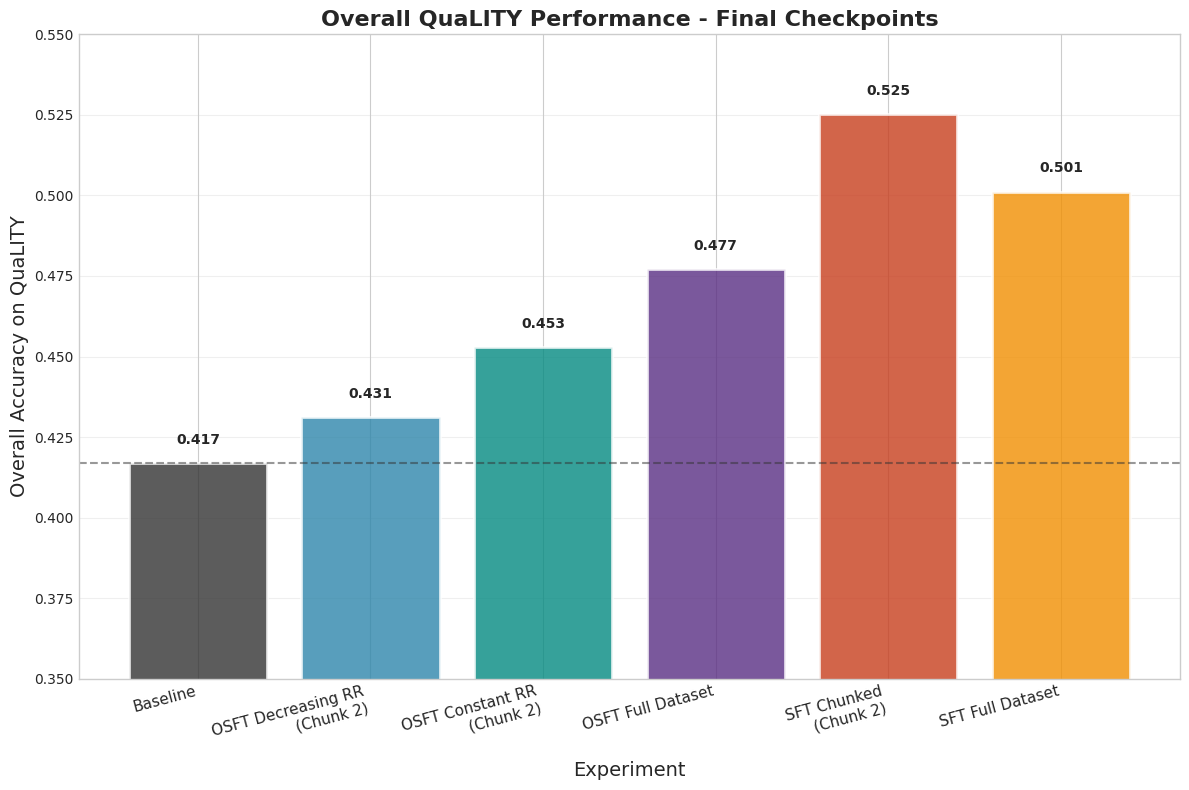

In [4]:
# plot 1: bar chart of overall quality performance (final chunks only)
fig = plt.figure(figsize=(12, 8))

# filter for final chunks and full dataset runs
final_runs = {
    'Baseline': experiments_data['Baseline'],
    'OSFT Decreasing RR\n(Chunk 2)': experiments_data['OSFT Decreasing RR - Chunk 2'],
    'OSFT Constant RR\n(Chunk 2)': experiments_data['OSFT Constant RR - Chunk 2'],
    'OSFT Full Dataset': experiments_data['OSFT Full Dataset'],
    'SFT Chunked\n(Chunk 2)': experiments_data['SFT Chunked - Chunk 2'],
    'SFT Full Dataset': experiments_data['SFT Full Dataset']
}

# prepare data for plotting
exp_names = list(final_runs.keys())
accuracies = [final_runs[exp]['quality_accuracy'] for exp in exp_names]

# assign colors based on method
colors = []
for exp in exp_names:
    if 'Baseline' in exp:
        colors.append('#333333')  # gray for baseline
    elif 'OSFT Decreasing' in exp:
        colors.append('#2E86AB')  # blue for osft decreasing
    elif 'OSFT Constant' in exp:
        colors.append('#048A81')  # teal for osft constant
    elif 'OSFT Full' in exp:
        colors.append('#592E83')  # purple for osft full
    elif 'SFT Chunked' in exp:
        colors.append('#C73E1D')  # red for sft chunked
    else:  # sft full
        colors.append('#F18F01')  # orange for sft full

# create bar plot
bars = plt.bar(range(len(exp_names)), accuracies, color=colors, alpha=0.8, edgecolor='white', linewidth=2)

# add value labels on top of bars
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{acc:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# customize plot
plt.xlabel('Experiment', fontsize=14)
plt.ylabel('Overall Accuracy on QuaLITY', fontsize=14)
plt.title('Overall QuaLITY Performance - Final Checkpoints', fontsize=16, fontweight='bold')
plt.xticks(range(len(exp_names)), exp_names, rotation=15, ha='right', fontsize=11)
plt.ylim(0.35, 0.55)
plt.grid(axis='y', alpha=0.3)

# add horizontal line for baseline reference
plt.axhline(y=experiments_data['Baseline']['quality_accuracy'], color='#333333', 
            linestyle='--', alpha=0.5, label='Baseline')

plt.tight_layout()
plt.show()


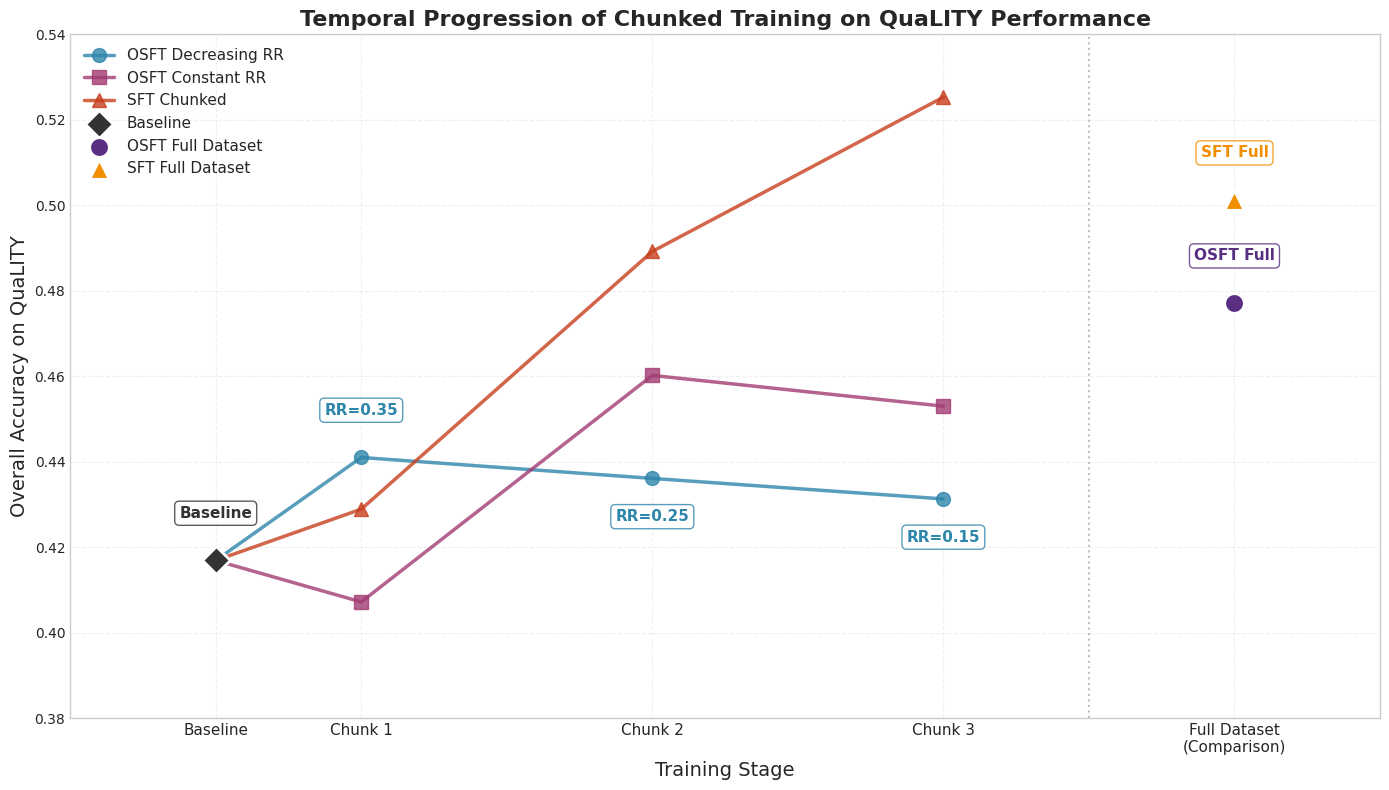

In [25]:
# plot 2: temporal plot of chunked runs' progression
fig = plt.figure(figsize=(14, 8))

# prepare data for temporal plot
# x-axis: baseline (0), chunk 0 (1), chunk 1 (2), chunk 2 (3), full dataset comparison (3.5)
x_positions = [-0.5, 0, 1, 2, 3]

# extract data for each method
osft_decreasing_y = [
    experiments_data['Baseline']['quality_accuracy'],  # baseline
    experiments_data['OSFT Decreasing RR - Chunk 0']['quality_accuracy'],
    experiments_data['OSFT Decreasing RR - Chunk 1']['quality_accuracy'],
    experiments_data['OSFT Decreasing RR - Chunk 2']['quality_accuracy'],
    experiments_data['OSFT Full Dataset']['quality_accuracy']  # for comparison
]

osft_constant_y = [
    experiments_data['Baseline']['quality_accuracy'],  # baseline
    experiments_data['OSFT Constant RR - Chunk 0']['quality_accuracy'],
    experiments_data['OSFT Constant RR - Chunk 1']['quality_accuracy'],
    experiments_data['OSFT Constant RR - Chunk 2']['quality_accuracy'],
    experiments_data['OSFT Full Dataset']['quality_accuracy']  # for comparison
]

sft_chunked_y = [
    experiments_data['Baseline']['quality_accuracy'],  # baseline
    experiments_data['SFT Chunked - Chunk 0']['quality_accuracy'],
    experiments_data['SFT Chunked - Chunk 1']['quality_accuracy'],
    experiments_data['SFT Chunked - Chunk 2']['quality_accuracy'],
    experiments_data['SFT Full Dataset']['quality_accuracy']  # for comparison
]

# plot chunked progressions (now connected from baseline through chunks 1-3)
plt.plot(x_positions[0:4], osft_decreasing_y[0:4], 'o-', color='#2E86AB', 
         linewidth=2.5, markersize=10, label='OSFT Decreasing RR', alpha=0.8)
plt.plot(x_positions[0:4], osft_constant_y[0:4], 's-', color='#A23B72',  # Changed to magenta for consistency
         linewidth=2.5, markersize=10, label='OSFT Constant RR', alpha=0.8)
plt.plot(x_positions[0:4], sft_chunked_y[0:4], '^-', color='#C73E1D', 
         linewidth=2.5, markersize=10, label='SFT Chunked', alpha=0.8)

# plot baseline as a starting reference point (with larger size to stand out)
plt.scatter(x_positions[0], experiments_data['Baseline']['quality_accuracy'], 
           color='#333333', s=200, marker='D', label='Baseline', zorder=5, edgecolors='white', linewidth=2)

# add label to baseline point
plt.annotate('Baseline', xy=(x_positions[0], experiments_data['Baseline']['quality_accuracy']), 
            xytext=(x_positions[0], experiments_data['Baseline']['quality_accuracy'] + 0.01), 
            ha='center', fontsize=11, color='#333333', fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#333333', alpha=0.8))

# plot full dataset runs as comparison points (not connected)
plt.scatter(x_positions[4], experiments_data['OSFT Full Dataset']['quality_accuracy'], 
           color='#592E83', s=200, marker='o', label='OSFT Full Dataset', zorder=5, edgecolors='white', linewidth=2)
plt.scatter(x_positions[4], experiments_data['SFT Full Dataset']['quality_accuracy'], 
           color='#F18F01', s=200, marker='^', label='SFT Full Dataset', zorder=5, edgecolors='white', linewidth=2)

# add labels to full dataset points (above the points like baseline)
plt.annotate('OSFT Full', xy=(x_positions[4], experiments_data['OSFT Full Dataset']['quality_accuracy']), 
            xytext=(x_positions[4], experiments_data['OSFT Full Dataset']['quality_accuracy'] + 0.01), 
            ha='center', fontsize=11, color='#592E83', fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#592E83', alpha=0.8))

plt.annotate('SFT Full', xy=(x_positions[4], experiments_data['SFT Full Dataset']['quality_accuracy']), 
            xytext=(x_positions[4], experiments_data['SFT Full Dataset']['quality_accuracy'] + 0.01), 
            ha='center', fontsize=11, color='#F18F01', fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#F18F01', alpha=0.8))

# add vertical separator line between chunked and full dataset
plt.axvline(x=2.5, color='gray', linestyle=':', alpha=0.5)

# add annotations for rank ratios on osft decreasing line
rr_values = [0.35, 0.25, 0.15]
for i in range(3):
    x = x_positions[i+1]
    y = osft_decreasing_y[i+1]
    # Position labels: first one above, others below
    if i == 0:  # Chunk 1 - above
        offset = 0.01
    elif i == 1:  # Chunk 2 - below
        offset = -0.01
    else:  # Chunk 3 - below
        offset = -0.01
    plt.annotate(f'RR={rr_values[i]}', xy=(x, y), xytext=(x, y+offset), 
                ha='center', fontsize=11, color='#2E86AB', fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#2E86AB', alpha=0.8))

# customize plot
plt.xlabel('Training Stage', fontsize=14)
plt.ylabel('Overall Accuracy on QuaLITY', fontsize=14)
plt.title('Temporal Progression of Chunked Training on QuaLITY Performance', fontsize=16, fontweight='bold')

# customize x-axis labels
plt.xticks(x_positions, ['Baseline', 'Chunk 1', 'Chunk 2', 'Chunk 3', 'Full Dataset\n(Comparison)'], 
          fontsize=11)
plt.xlim(-1, 3.5)
plt.ylim(0.38, 0.54)

# add grid for better readability
plt.grid(True, alpha=0.3, linestyle='--')

# add legend
plt.legend(loc='upper left', fontsize=11, framealpha=0.9)

# removed redundant annotation since we now have proper labels

plt.tight_layout()
plt.show()


In [6]:
# extract domain-specific quality scores (each chunk evaluated on its own data)
domain_specific_scores = {
    'Chunk 1': {
        'Base Model': 0.4446,
        'OSFT Decreasing RR': 0.5202,
        'OSFT Constant RR': 0.5176,
        'SFT Chunked': 0.5319
    },
    'Chunk 2': {
        'Base Model': 0.4360,
        'OSFT Decreasing RR': 0.5000,
        'OSFT Constant RR': 0.5026,
        'SFT Chunked': 0.5235
    },
    'Chunk 3': {
        'Base Model': 0.4135,
        'OSFT Decreasing RR': 0.4449,
        'OSFT Constant RR': 0.4586,
        'SFT Chunked': 0.5163
    }
}

print("Domain-specific QuaLITY scores loaded successfully!")


Domain-specific QuaLITY scores loaded successfully!


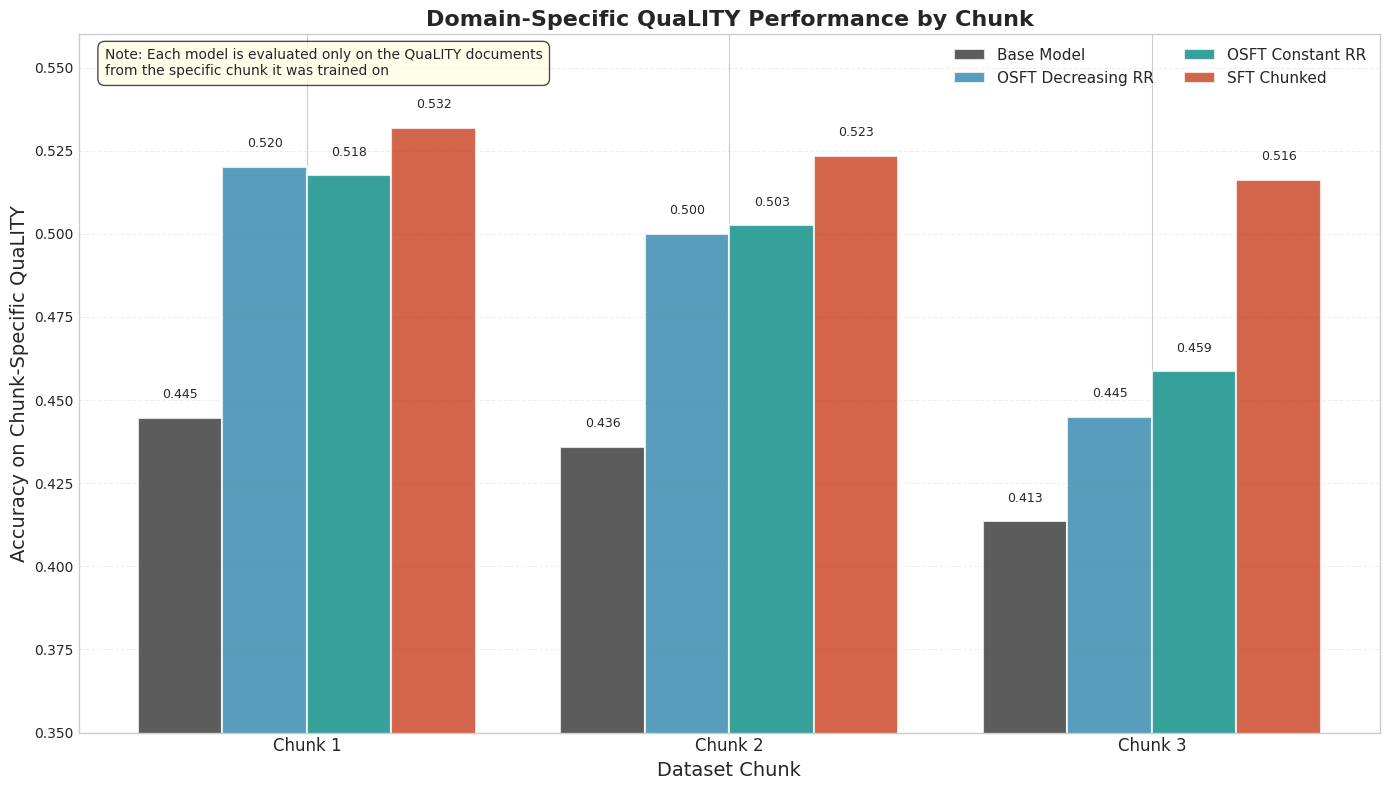

In [7]:
# plot 3: domain-specific quality scores (grouped bar chart by chunk)
fig, ax = plt.subplots(figsize=(14, 8))

# prepare data for grouped bar chart
chunks = list(domain_specific_scores.keys())
methods = ['Base Model', 'OSFT Decreasing RR', 'OSFT Constant RR', 'SFT Chunked']

# extract scores for each method across chunks
base_scores = [domain_specific_scores[chunk]['Base Model'] for chunk in chunks]
osft_dec_scores = [domain_specific_scores[chunk]['OSFT Decreasing RR'] for chunk in chunks]
osft_const_scores = [domain_specific_scores[chunk]['OSFT Constant RR'] for chunk in chunks]
sft_scores = [domain_specific_scores[chunk]['SFT Chunked'] for chunk in chunks]

# set up bar positions
x = np.arange(len(chunks))  # chunk positions
width = 0.2  # width of bars
multiplier = 0

# define colors for each method
method_colors = {
    'Base Model': '#333333',        # gray
    'OSFT Decreasing RR': '#2E86AB', # blue
    'OSFT Constant RR': '#048A81',   # teal
    'SFT Chunked': '#C73E1D'         # red
}

# create grouped bars
scores_by_method = {
    'Base Model': base_scores,
    'OSFT Decreasing RR': osft_dec_scores,
    'OSFT Constant RR': osft_const_scores,
    'SFT Chunked': sft_scores
}

for method, scores in scores_by_method.items():
    offset = width * multiplier
    bars = ax.bar(x + offset, scores, width, label=method, 
                   color=method_colors[method], alpha=0.8, edgecolor='white', linewidth=1.5)
    
    # add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    multiplier += 1

# customize plot
ax.set_xlabel('Dataset Chunk', fontsize=14)
ax.set_ylabel('Accuracy on Chunk-Specific QuaLITY', fontsize=14)
ax.set_title('Domain-Specific QuaLITY Performance by Chunk', fontsize=16, fontweight='bold')
ax.set_xticks(x + width * 1.5)  # center the labels
ax.set_xticklabels(chunks, fontsize=12)
ax.legend(loc='upper right', ncol=2, fontsize=11, framealpha=0.9)
ax.set_ylim(0.35, 0.56)

# add grid for better readability
ax.yaxis.grid(True, alpha=0.3, linestyle='--')

# add annotation explaining what domain-specific means
ax.text(0.02, 0.98, 'Note: Each model is evaluated only on the QuaLITY documents\nfrom the specific chunk it was trained on', 
        transform=ax.transAxes, fontsize=10, va='top', ha='left',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.7))

plt.tight_layout()
plt.show()


### Key Observations from Domain-Specific QuaLITY Scores

- **SFT consistently outperforms OSFT methods** on chunk-specific evaluations across all chunks
- **Chunk 0 shows the best performance** for all methods (Base: 44.46%, SFT: 53.19%, OSFT methods: ~51-52%)
- **Chunk 2 shows the worst baseline performance** (41.35%) and also the largest gap between OSFT methods and SFT
- **OSFT Decreasing RR performance degrades significantly by Chunk 2** (44.49%), falling below other OSFT/SFT methods
- **All trained models show substantial improvement** over baseline (6-10 percentage points)
- **OSFT Constant RR maintains more stable performance** compared to OSFT Decreasing RR across chunks


In [8]:
# extract progressive quality scores
# progressive evaluation: each checkpoint is evaluated on all chunks up to and including the current one
progressive_scores = {
    'Chunk 1 Progressive': {
        'Base Model': 0.4394,
        'OSFT Decreasing RR': 0.5202,
        'OSFT Constant RR': 0.5202,
        'SFT Chunked': 0.5398
    },
    'Chunk 2 Progressive': {
        'Base Model': 0.4310,
        'OSFT Decreasing RR': 0.5083,
        'OSFT Constant RR': 0.5182,
        'SFT Chunked': 0.5274
    },
    'Chunk 3 Progressive': {
        'Base Model': 0.4305,
        'OSFT Decreasing RR': 0.4815,
        'OSFT Constant RR': 0.5020,
        'SFT Chunked': 0.5290
    }
}

# also need the full dataset results for comparison
full_dataset_scores = {
    'Baseline': 0.4169,  # original baseline
    'OSFT Full Dataset': 0.4771,
    'SFT Full Dataset': 0.5012
}

print("Progressive QuaLITY scores loaded successfully!")


Progressive QuaLITY scores loaded successfully!


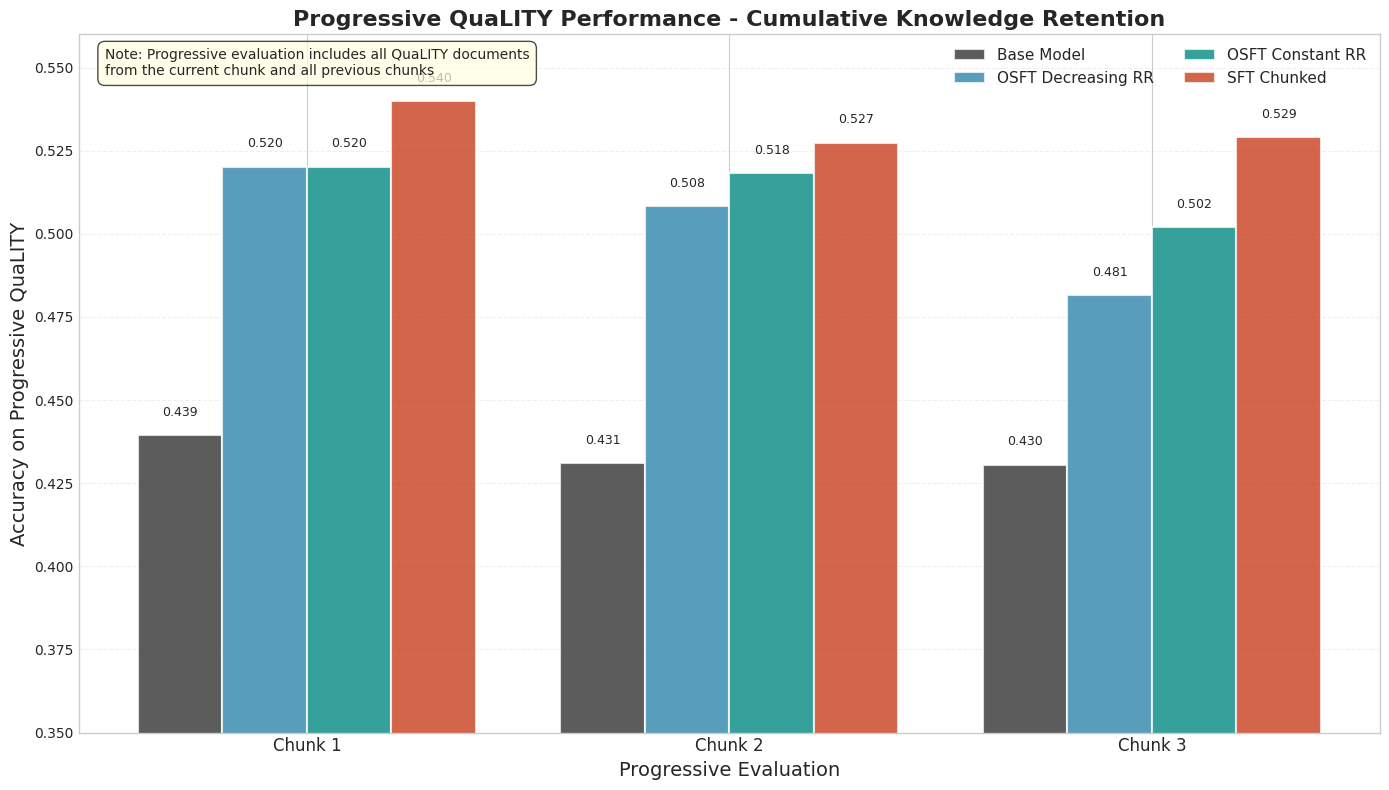

In [9]:
# plot 4: progressive quality scores (grouped bar chart)
fig, ax = plt.subplots(figsize=(14, 8))

# prepare data for grouped bar chart
progressive_chunks = list(progressive_scores.keys())
methods = ['Base Model', 'OSFT Decreasing RR', 'OSFT Constant RR', 'SFT Chunked']

# extract scores for each method across progressive evaluations
base_prog_scores = [progressive_scores[chunk]['Base Model'] for chunk in progressive_chunks]
osft_dec_prog_scores = [progressive_scores[chunk]['OSFT Decreasing RR'] for chunk in progressive_chunks]
osft_const_prog_scores = [progressive_scores[chunk]['OSFT Constant RR'] for chunk in progressive_chunks]
sft_prog_scores = [progressive_scores[chunk]['SFT Chunked'] for chunk in progressive_chunks]

# set up bar positions
x = np.arange(len(progressive_chunks))  # chunk positions
width = 0.2  # width of bars
multiplier = 0

# define colors for each method (same as before)
method_colors = {
    'Base Model': '#333333',        # gray
    'OSFT Decreasing RR': '#2E86AB', # blue
    'OSFT Constant RR': '#048A81',   # teal
    'SFT Chunked': '#C73E1D'         # red
}

# create grouped bars
scores_by_method = {
    'Base Model': base_prog_scores,
    'OSFT Decreasing RR': osft_dec_prog_scores,
    'OSFT Constant RR': osft_const_prog_scores,
    'SFT Chunked': sft_prog_scores
}

for method, scores in scores_by_method.items():
    offset = width * multiplier
    bars = ax.bar(x + offset, scores, width, label=method, 
                   color=method_colors[method], alpha=0.8, edgecolor='white', linewidth=1.5)
    
    # add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    multiplier += 1

# customize plot
ax.set_xlabel('Progressive Evaluation', fontsize=14)
ax.set_ylabel('Accuracy on Progressive QuaLITY', fontsize=14)
ax.set_title('Progressive QuaLITY Performance - Cumulative Knowledge Retention', fontsize=16, fontweight='bold')
ax.set_xticks(x + width * 1.5)  # center the labels
ax.set_xticklabels([chunk.replace(' Progressive', '') for chunk in progressive_chunks], fontsize=12)
ax.legend(loc='upper right', ncol=2, fontsize=11, framealpha=0.9)
ax.set_ylim(0.35, 0.56)

# add grid for better readability
ax.yaxis.grid(True, alpha=0.3, linestyle='--')

# add annotation explaining what progressive means
ax.text(0.02, 0.98, 'Note: Progressive evaluation includes all QuaLITY documents\nfrom the current chunk and all previous chunks', 
        transform=ax.transAxes, fontsize=10, va='top', ha='left',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.7))

plt.tight_layout()
plt.show()


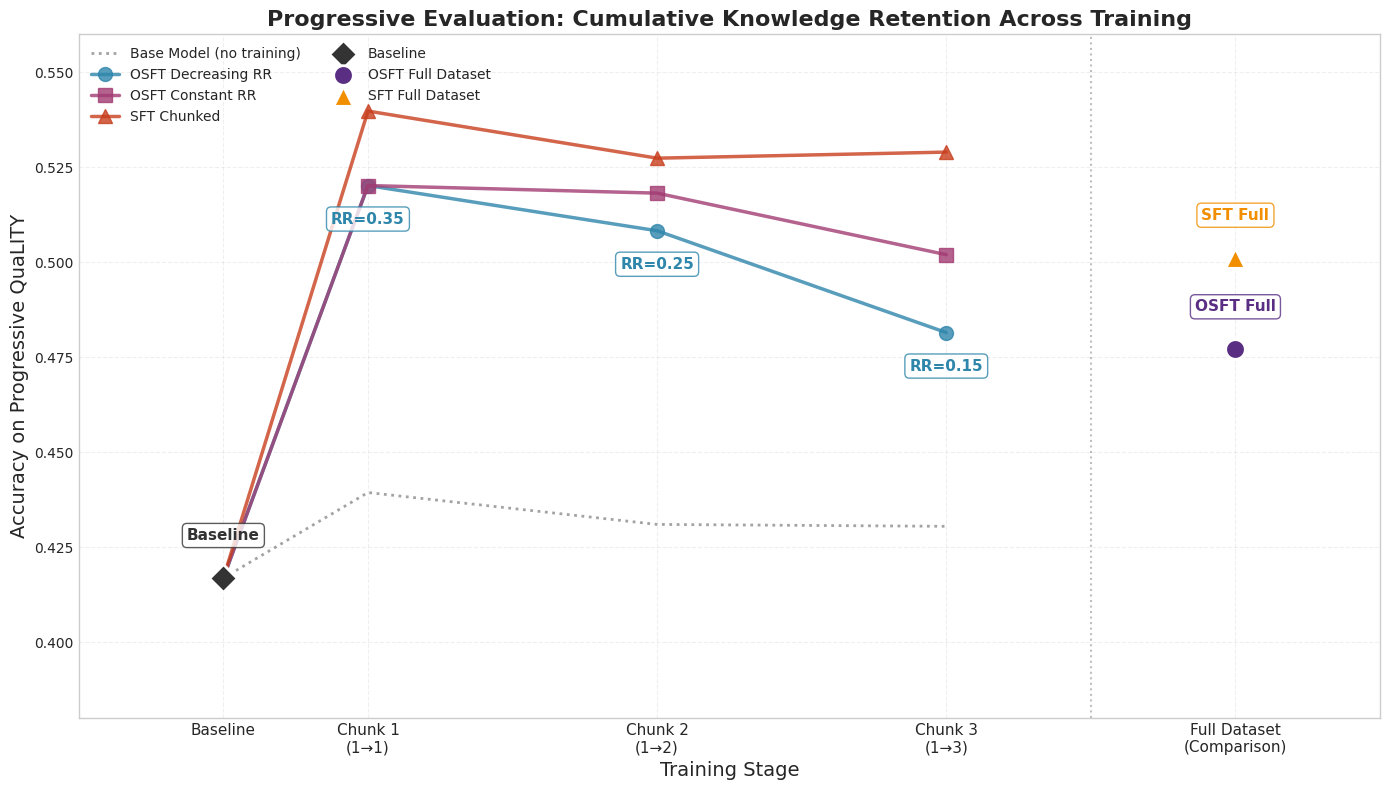

In [27]:
# plot 5: temporal plot of progressive evaluation performance
fig = plt.figure(figsize=(14, 8))

# prepare data for temporal plot
# x-axis: baseline (-0.5), chunk 0 (0), chunk 1 (1), chunk 2 (2), full dataset comparison (3)
x_positions = [-0.5, 0, 1, 2, 3]

# extract data for each method on progressive evaluation
osft_decreasing_prog = [
    full_dataset_scores['Baseline'],  # baseline
    progressive_scores['Chunk 1 Progressive']['OSFT Decreasing RR'],
    progressive_scores['Chunk 2 Progressive']['OSFT Decreasing RR'],
    progressive_scores['Chunk 3 Progressive']['OSFT Decreasing RR'],
    full_dataset_scores['OSFT Full Dataset']  # for comparison
]

osft_constant_prog = [
    full_dataset_scores['Baseline'],  # baseline
    progressive_scores['Chunk 1 Progressive']['OSFT Constant RR'],
    progressive_scores['Chunk 2 Progressive']['OSFT Constant RR'],
    progressive_scores['Chunk 3 Progressive']['OSFT Constant RR'],
    full_dataset_scores['OSFT Full Dataset']  # for comparison
]

sft_chunked_prog = [
    full_dataset_scores['Baseline'],  # baseline
    progressive_scores['Chunk 1 Progressive']['SFT Chunked'],
    progressive_scores['Chunk 2 Progressive']['SFT Chunked'],
    progressive_scores['Chunk 3 Progressive']['SFT Chunked'],
    full_dataset_scores['SFT Full Dataset']  # for comparison
]

# plot base model progression separately (dotted line)
base_model_prog = [
    full_dataset_scores['Baseline'],
    progressive_scores['Chunk 1 Progressive']['Base Model'],
    progressive_scores['Chunk 2 Progressive']['Base Model'],
    progressive_scores['Chunk 3 Progressive']['Base Model'],
    full_dataset_scores['Baseline']  # baseline doesn't change
]

# plot base model progression (dotted line)
plt.plot(x_positions[0:4], base_model_prog[0:4], ':', color='#666666', 
         linewidth=2, markersize=8, label='Base Model (no training)', alpha=0.6)

# plot chunked progressions (now connected from baseline through chunks 1-3)
plt.plot(x_positions[0:4], osft_decreasing_prog[0:4], 'o-', color='#2E86AB', 
         linewidth=2.5, markersize=10, label='OSFT Decreasing RR', alpha=0.8)
plt.plot(x_positions[0:4], osft_constant_prog[0:4], 's-', color='#A23B72',  # Changed to magenta for consistency
         linewidth=2.5, markersize=10, label='OSFT Constant RR', alpha=0.8)
plt.plot(x_positions[0:4], sft_chunked_prog[0:4], '^-', color='#C73E1D', 
         linewidth=2.5, markersize=10, label='SFT Chunked', alpha=0.8)

# plot baseline as a starting reference point (with larger size to stand out)
plt.scatter(x_positions[0], full_dataset_scores['Baseline'], 
           color='#333333', s=200, marker='D', label='Baseline', zorder=5, edgecolors='white', linewidth=2)

# add label to baseline point
plt.annotate('Baseline', xy=(x_positions[0], full_dataset_scores['Baseline']), 
            xytext=(x_positions[0], full_dataset_scores['Baseline'] + 0.01), 
            ha='center', fontsize=11, color='#333333', fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#333333', alpha=0.8))

# plot full dataset runs as comparison points (not connected)
plt.scatter(x_positions[4], full_dataset_scores['OSFT Full Dataset'], 
           color='#592E83', s=200, marker='o', label='OSFT Full Dataset', zorder=5, edgecolors='white', linewidth=2)
plt.scatter(x_positions[4], full_dataset_scores['SFT Full Dataset'], 
           color='#F18F01', s=200, marker='^', label='SFT Full Dataset', zorder=5, edgecolors='white', linewidth=2)

# add labels to full dataset points (above the points like baseline)
plt.annotate('OSFT Full', xy=(x_positions[4], full_dataset_scores['OSFT Full Dataset']), 
            xytext=(x_positions[4], full_dataset_scores['OSFT Full Dataset'] + 0.01), 
            ha='center', fontsize=11, color='#592E83', fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#592E83', alpha=0.8))

plt.annotate('SFT Full', xy=(x_positions[4], full_dataset_scores['SFT Full Dataset']), 
            xytext=(x_positions[4], full_dataset_scores['SFT Full Dataset'] + 0.01), 
            ha='center', fontsize=11, color='#F18F01', fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#F18F01', alpha=0.8))

# add vertical separator line between chunked and full dataset
plt.axvline(x=2.5, color='gray', linestyle=':', alpha=0.5)

# add annotations for rank ratios on osft decreasing line
rr_values = [0.35, 0.25, 0.15]
for i in range(3):
    x = x_positions[i+1]
    y = osft_decreasing_prog[i+1]
    # Position labels below the line, closer to points
    plt.annotate(f'RR={rr_values[i]}', xy=(x, y), xytext=(x, y-0.01), 
                ha='center', fontsize=11, color='#2E86AB', fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#2E86AB', alpha=0.8))

# customize plot
plt.xlabel('Training Stage', fontsize=14)
plt.ylabel('Accuracy on Progressive QuaLITY', fontsize=14)
plt.title('Progressive Evaluation: Cumulative Knowledge Retention Across Training', fontsize=16, fontweight='bold')

# customize x-axis labels
plt.xticks(x_positions, ['Baseline', 'Chunk 1\n(1→1)', 'Chunk 2\n(1→2)', 'Chunk 3\n(1→3)', 'Full Dataset\n(Comparison)'], 
          fontsize=11)
plt.xlim(-1, 3.5)
plt.ylim(0.38, 0.56)

# add grid for better readability
plt.grid(True, alpha=0.3, linestyle='--')

# add legend
plt.legend(loc='upper left', fontsize=10, framealpha=0.9, ncol=2)

# removed redundant annotations since we now have proper labels

plt.tight_layout()
plt.show()


### Key Observations from Progressive Evaluation Plots

#### Plot 4: Progressive QuaLITY Scores (Grouped Bar Chart)
- **All methods show declining performance** as they evaluate on larger cumulative datasets
- **SFT Chunked maintains the lead** across all progressive evaluations (53.98% → 52.74% → 52.90%)
- **OSFT Decreasing RR shows steepest decline** (52.02% → 50.83% → 48.15%)
- **Base model remains relatively stable** (43.94% → 43.10% → 43.05%), showing no catastrophic forgetting
- **Performance gap widens** between methods as more chunks are included

#### Plot 5: Temporal Progression of Progressive Evaluation
- **SFT Chunked shows remarkable stability** - actually improves slightly from Chunk 1 to Chunk 2
- **OSFT Constant RR maintains steady performance** with gradual decline (52.02% → 51.82% → 50.20%)
- **OSFT Decreasing RR shows concerning degradation** as rank ratio decreases
- **Full dataset comparisons reveal**:
  - OSFT Full Dataset (47.71%) underperforms all chunked methods at Chunk 2
  - SFT Full Dataset (50.12%) also underperforms SFT Chunked final checkpoint (52.90%)
- **Base model progression** shows the inherent difficulty differences across chunks


In [11]:
# extract leaderboard scores from experiment outline
leaderboard_data = {
    'Baseline': {
        'Overall': 41.72,  # from experiment 1
        'BBH': 51.01,
        'GPQA': 27.25,
        'IFEval': 77.55,
        'MATH-Hard': 18.13,
        'MMLU-Pro': 37.78,
        'MUSR': 38.57
    },
    'OSFT Decreasing RR - Chunk 1': {
        'Overall': 42.49,
        'BBH': 50.21,
        'GPQA': 29.90,
        'IFEval': 77.37,
        'MATH-Hard': 17.24,
        'MMLU-Pro': 37.97,
        'MUSR': 42.25
    },
    'OSFT Decreasing RR - Chunk 2': {
        'Overall': 41.26,
        'BBH': 49.22,
        'GPQA': 30.74,
        'IFEval': 74.72,
        'MATH-Hard': 14.44,
        'MMLU-Pro': 36.98,
        'MUSR': 41.46
    },
    'OSFT Decreasing RR - Chunk 3': {
        'Overall': 40.90,
        'BBH': 49.37,
        'GPQA': 29.94,
        'IFEval': 73.35,
        'MATH-Hard': 13.94,
        'MMLU-Pro': 36.29,
        'MUSR': 42.53
    },
    'OSFT Constant RR - Chunk 1': {
        'Overall': 42.52,
        'BBH': 50.16,
        'GPQA': 31.52,
        'IFEval': 75.88,
        'MATH-Hard': 16.74,
        'MMLU-Pro': 38.04,
        'MUSR': 42.78
    },
    'OSFT Constant RR - Chunk 2': {
        'Overall': 41.65,
        'BBH': 49.58,
        'GPQA': 31.23,
        'IFEval': 74.54,
        'MATH-Hard': 16.49,
        'MMLU-Pro': 36.88,
        'MUSR': 41.19
    },
    'OSFT Constant RR - Chunk 3': {
        'Overall': 40.92,
        'BBH': 49.91,
        'GPQA': 31.36,
        'IFEval': 72.62,
        'MATH-Hard': 13.85,
        'MMLU-Pro': 36.74,
        'MUSR': 41.07
    },
    'OSFT Full Dataset': {
        'Overall': 41.88,
        'BBH': 49.25,
        'GPQA': 32.20,
        'IFEval': 76.00,
        'MATH-Hard': 15.19,
        'MMLU-Pro': 37.67,
        'MUSR': 40.93
    },
    'SFT Chunked - Chunk 1': {
        'Overall': 39.82,
        'BBH': 50.23,
        'GPQA': 31.97,
        'IFEval': 65.41,
        'MATH-Hard': 14.52,
        'MMLU-Pro': 37.14,
        'MUSR': 39.62
    },
    'SFT Chunked - Chunk 2': {
        'Overall': 39.77,
        'BBH': 50.19,
        'GPQA': 31.95,
        'IFEval': 66.44,
        'MATH-Hard': 15.37,
        'MMLU-Pro': 36.50,
        'MUSR': 38.17
    },
    'SFT Chunked - Chunk 3': {
        'Overall': 38.61,
        'BBH': 50.28,
        'GPQA': 30.10,
        'IFEval': 63.80,
        'MATH-Hard': 13.94,
        'MMLU-Pro': 35.64,
        'MUSR': 37.91
    },
    'SFT Full Dataset': {
        'Overall': 39.40,
        'BBH': 49.96,
        'GPQA': 32.63,
        'IFEval': 63.16,
        'MATH-Hard': 14.73,
        'MMLU-Pro': 36.29,
        'MUSR': 39.61
    }
}

print("Leaderboard data loaded successfully!")
print(f"Total experiments: {len(leaderboard_data)}")


Leaderboard data loaded successfully!
Total experiments: 12


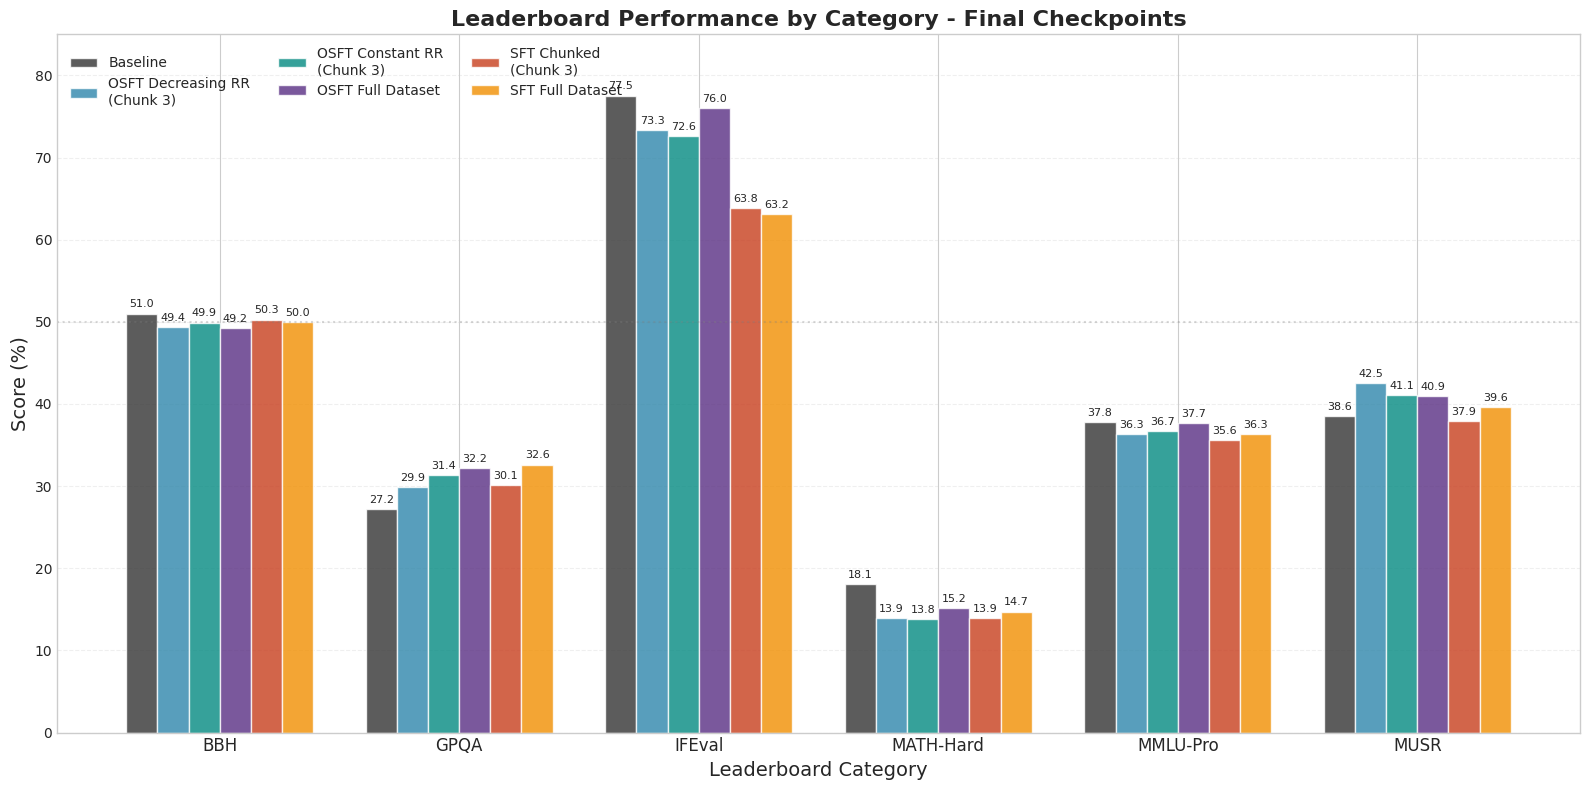

In [29]:
# plot 6: leaderboard performance by category (bar plot)
fig, ax = plt.subplots(figsize=(16, 8))

# select final checkpoints and full dataset runs for comparison
final_models = {
    'Baseline': leaderboard_data['Baseline'],
    'OSFT Decreasing RR\n(Chunk 3)': leaderboard_data['OSFT Decreasing RR - Chunk 3'],
    'OSFT Constant RR\n(Chunk 3)': leaderboard_data['OSFT Constant RR - Chunk 3'],
    'OSFT Full Dataset': leaderboard_data['OSFT Full Dataset'],
    'SFT Chunked\n(Chunk 3)': leaderboard_data['SFT Chunked - Chunk 3'],
    'SFT Full Dataset': leaderboard_data['SFT Full Dataset']
}

# extract categories (excluding 'Overall')
categories = ['BBH', 'GPQA', 'IFEval', 'MATH-Hard', 'MMLU-Pro', 'MUSR']
models = list(final_models.keys())

# set up bar positions
x = np.arange(len(categories))
width = 0.13  # width of bars (adjusted for 6 models)
multiplier = 0

# define colors for each model
model_colors = {
    'Baseline': '#333333',                    # gray
    'OSFT Decreasing RR\n(Chunk 3)': '#2E86AB',  # blue
    'OSFT Constant RR\n(Chunk 3)': '#048A81',    # teal
    'OSFT Full Dataset': '#592E83',              # purple
    'SFT Chunked\n(Chunk 3)': '#C73E1D',         # red
    'SFT Full Dataset': '#F18F01'                # orange
}

# create grouped bars for each model
for model in models:
    scores = [final_models[model][cat] for cat in categories]
    offset = width * multiplier
    bars = ax.bar(x + offset, scores, width, label=model, 
                   color=model_colors[model], alpha=0.8, edgecolor='white', linewidth=1)
    
    # add value labels on top of bars (lowered threshold to include MATH-Hard)
    for bar in bars:
        height = bar.get_height()
        if height > 10:  # Lowered from 20 to show MATH-Hard values
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{height:.1f}', ha='center', va='bottom', fontsize=8)
    
    multiplier += 1

# customize plot
ax.set_xlabel('Leaderboard Category', fontsize=14)
ax.set_ylabel('Score (%)', fontsize=14)
ax.set_title('Leaderboard Performance by Category - Final Checkpoints', fontsize=16, fontweight='bold')
ax.set_xticks(x + width * 2.5)  # center the labels
ax.set_xticklabels(categories, fontsize=12)
ax.legend(loc='upper left', ncol=3, fontsize=10, framealpha=0.9)
ax.set_ylim(0, 85)

# add grid for better readability
ax.yaxis.grid(True, alpha=0.3, linestyle='--')

# add horizontal line for baseline reference on key metrics
ax.axhline(y=50, color='gray', linestyle=':', alpha=0.3, label='50% threshold')

plt.tight_layout()
plt.show()


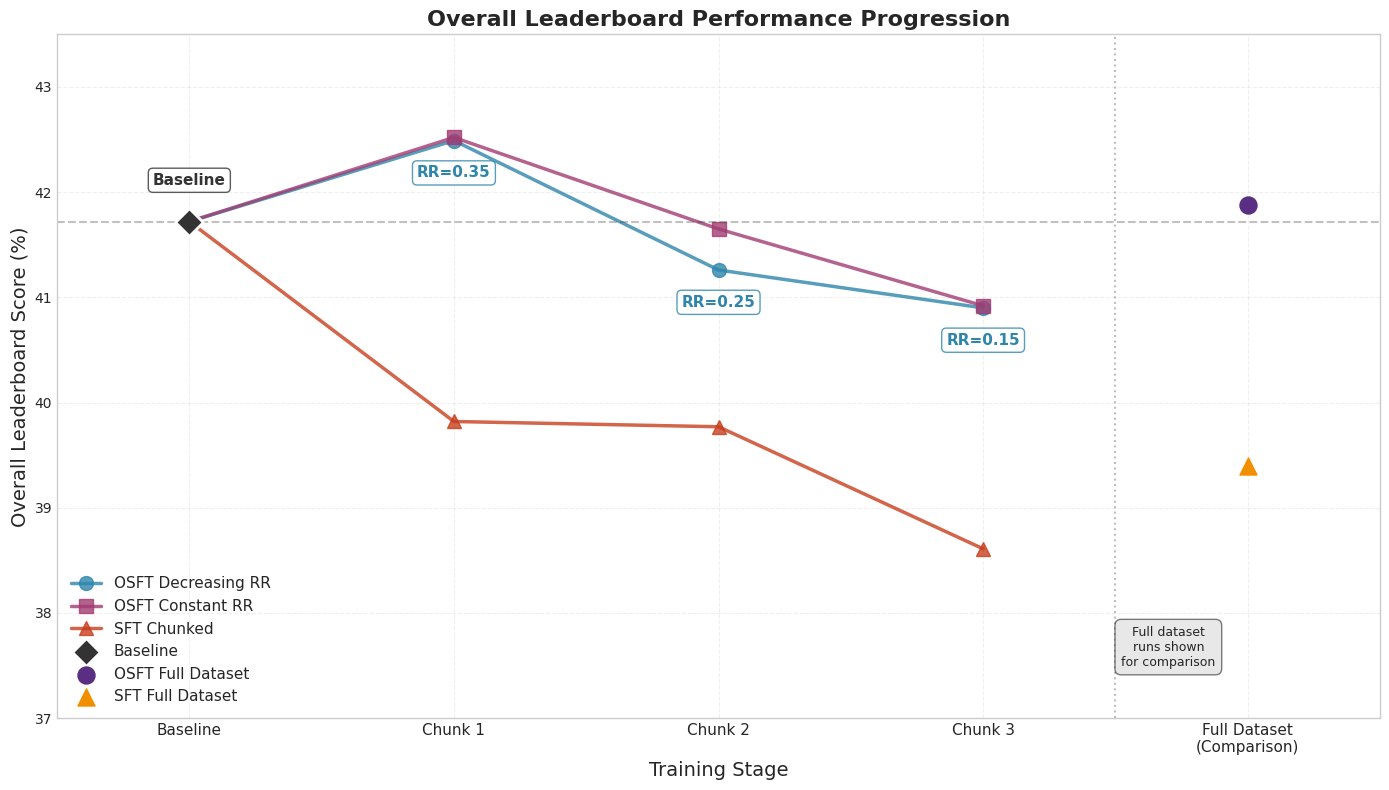

In [28]:
# plot 7: temporal plot of overall leaderboard performance
fig = plt.figure(figsize=(14, 8))

# prepare data for temporal plot
# x-axis: baseline (0), chunk 1 (1), chunk 2 (2), chunk 3 (3), full dataset comparison (4)
x_positions = [0, 1, 2, 3, 4]

# extract overall scores for each method
osft_decreasing_overall = [
    leaderboard_data['Baseline']['Overall'],
    leaderboard_data['OSFT Decreasing RR - Chunk 1']['Overall'],
    leaderboard_data['OSFT Decreasing RR - Chunk 2']['Overall'],
    leaderboard_data['OSFT Decreasing RR - Chunk 3']['Overall'],
    leaderboard_data['OSFT Full Dataset']['Overall']
]

osft_constant_overall = [
    leaderboard_data['Baseline']['Overall'],
    leaderboard_data['OSFT Constant RR - Chunk 1']['Overall'],
    leaderboard_data['OSFT Constant RR - Chunk 2']['Overall'],
    leaderboard_data['OSFT Constant RR - Chunk 3']['Overall'],
    leaderboard_data['OSFT Full Dataset']['Overall']
]

sft_chunked_overall = [
    leaderboard_data['Baseline']['Overall'],
    leaderboard_data['SFT Chunked - Chunk 1']['Overall'],
    leaderboard_data['SFT Chunked - Chunk 2']['Overall'],
    leaderboard_data['SFT Chunked - Chunk 3']['Overall'],
    leaderboard_data['SFT Full Dataset']['Overall']
]

# plot chunked progressions (now connected from baseline through chunks 1-3)
plt.plot(x_positions[0:4], osft_decreasing_overall[0:4], 'o-', color='#2E86AB', 
         linewidth=2.5, markersize=10, label='OSFT Decreasing RR', alpha=0.8)
plt.plot(x_positions[0:4], osft_constant_overall[0:4], 's-', color='#A23B72',  # Changed to magenta for better contrast
         linewidth=2.5, markersize=10, label='OSFT Constant RR', alpha=0.8)
plt.plot(x_positions[0:4], sft_chunked_overall[0:4], '^-', color='#C73E1D', 
         linewidth=2.5, markersize=10, label='SFT Chunked', alpha=0.8)

# plot baseline as a starting reference point (with larger size to stand out)
plt.scatter(x_positions[0], leaderboard_data['Baseline']['Overall'], 
           color='#333333', s=200, marker='D', label='Baseline', zorder=5, edgecolors='white', linewidth=2)

# add label to baseline point
plt.annotate('Baseline', xy=(x_positions[0], leaderboard_data['Baseline']['Overall']), 
            xytext=(x_positions[0], leaderboard_data['Baseline']['Overall'] + 0.35), 
            ha='center', fontsize=11, color='#333333', fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#333333', alpha=0.8))

# plot full dataset runs as comparison points (not connected)
plt.scatter(x_positions[4], leaderboard_data['OSFT Full Dataset']['Overall'], 
           color='#592E83', s=150, marker='o', label='OSFT Full Dataset', zorder=5)
plt.scatter(x_positions[4], leaderboard_data['SFT Full Dataset']['Overall'], 
           color='#F18F01', s=150, marker='^', label='SFT Full Dataset', zorder=5)

# add vertical separator line between chunked and full dataset
plt.axvline(x=3.5, color='gray', linestyle=':', alpha=0.5)

# add annotations for rank ratios on osft decreasing line
rr_values = [0.35, 0.25, 0.15]
for i in range(3):
    x = x_positions[i+1]
    y = osft_decreasing_overall[i+1]
    # Position labels below the line to avoid overlap with constant RR line
    plt.annotate(f'RR={rr_values[i]}', xy=(x, y), xytext=(x, y-0.35), 
                ha='center', fontsize=11, color='#2E86AB', fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#2E86AB', alpha=0.8))

# Removed the floating 42.5% label

# customize plot
plt.xlabel('Training Stage', fontsize=14)
plt.ylabel('Overall Leaderboard Score (%)', fontsize=14)
plt.title('Overall Leaderboard Performance Progression', fontsize=16, fontweight='bold')

# customize x-axis labels
plt.xticks(x_positions, ['Baseline', 'Chunk 1', 'Chunk 2', 'Chunk 3', 'Full Dataset\n(Comparison)'], 
          fontsize=11)
plt.xlim(-0.5, 4.5)
plt.ylim(37, 43.5)

# add grid for better readability
plt.grid(True, alpha=0.3, linestyle='--')

# add legend
plt.legend(loc='lower left', fontsize=11, framealpha=0.9)

# add text annotation explaining the plot
plt.text(3.7, 37.5, 'Full dataset\nruns shown\nfor comparison', 
         fontsize=9, ha='center', bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.5))

# add horizontal baseline reference
plt.axhline(y=leaderboard_data['Baseline']['Overall'], color='#333333', 
            linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


### Key Observations from Leaderboard Performance Plots

#### Plot 6: Leaderboard Performance by Category
- **IFEval (Instruction Following)**: OSFT models significantly outperform SFT (72-77% vs 63-66%)
- **BBH**: All models perform similarly around 49-50%
- **MATH-Hard**: All models struggle, with scores below 20%
- **GPQA**: Full dataset models tend to perform slightly better
- **OSFT models show balanced performance** across categories while maintaining instruction-following capability

#### Plot 7: Overall Leaderboard Performance Progression
- **OSFT methods initially improve** (Chunk 1) but then decline with subsequent chunks
- **OSFT Constant RR shows best overall performance** at Chunk 1 (42.52%)
- **All chunked methods deteriorate** as training progresses, unlike QuaLITY performance
- **SFT shows steepest decline** from 39.82% (Chunk 1) to 38.61% (Chunk 3)
- **Full dataset training yields mixed results**: OSFT Full (41.88%) outperforms its chunked variants, but SFT Full (39.40%) is comparable to chunked


## Key Observations from the Plots

### Plot 1: Overall QuaLITY Performance (Final Checkpoints)
- **SFT Chunked achieves the highest accuracy** (52.53%) among all methods
- **OSFT methods show lower but more stable performance** compared to SFT
- **OSFT Decreasing RR performs worse** (43.13%) than OSFT Constant RR (45.30%), suggesting that reducing rank ratio hurts performance
- All training methods improve over the baseline (41.69%)

### Plot 2: Temporal Progression of Chunked Training
- **SFT Chunked shows the steepest improvement** as it trains on more chunks
- **OSFT Constant RR shows steady improvement** across chunks
- **OSFT Decreasing RR shows declining performance** as rank ratio decreases (RR: 0.35 → 0.25 → 0.15)
- The full dataset runs (shown at the end for comparison) perform differently than their chunked counterparts:
  - OSFT Full Dataset (47.71%) outperforms all OSFT chunked final checkpoints
  - SFT Full Dataset (50.12%) underperforms compared to SFT Chunked final checkpoint


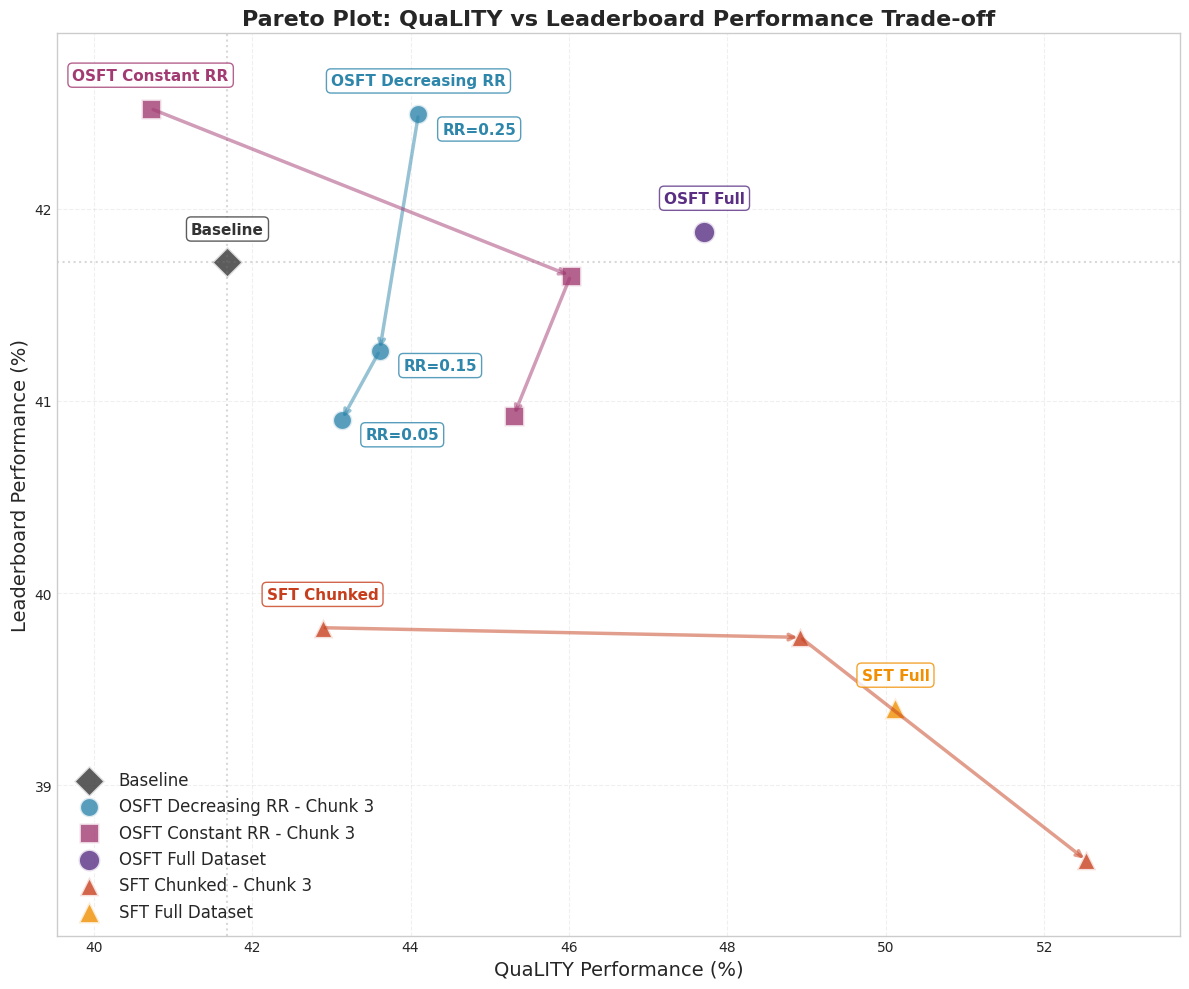

In [35]:
# plot 8: pareto plot - quality vs leaderboard performance
fig, ax = plt.subplots(figsize=(12, 10))

# prepare data for pareto plot
# we need to map quality scores to leaderboard scores for each experiment
pareto_data = {
    'Baseline': {
        'quality': experiments_data['Baseline']['quality_accuracy'] * 100,  # convert to percentage
        'leaderboard': leaderboard_data['Baseline']['Overall'],
        'method': 'baseline',
        'marker': 'D',
        'color': '#333333',
        'size': 250
    },
    'OSFT Decreasing RR - Chunk 1': {
        'quality': experiments_data['OSFT Decreasing RR - Chunk 0']['quality_accuracy'] * 100,
        'leaderboard': leaderboard_data['OSFT Decreasing RR - Chunk 1']['Overall'],
        'method': 'osft_decreasing',
        'marker': 'o',
        'color': '#2E86AB',
        'size': 200
    },
    'OSFT Decreasing RR - Chunk 2': {
        'quality': experiments_data['OSFT Decreasing RR - Chunk 1']['quality_accuracy'] * 100,
        'leaderboard': leaderboard_data['OSFT Decreasing RR - Chunk 2']['Overall'],
        'method': 'osft_decreasing',
        'marker': 'o',
        'color': '#2E86AB',
        'size': 200
    },
    'OSFT Decreasing RR - Chunk 3': {
        'quality': experiments_data['OSFT Decreasing RR - Chunk 2']['quality_accuracy'] * 100,
        'leaderboard': leaderboard_data['OSFT Decreasing RR - Chunk 3']['Overall'],
        'method': 'osft_decreasing',
        'marker': 'o',
        'color': '#2E86AB',
        'size': 200
    },
    'OSFT Constant RR - Chunk 1': {
        'quality': experiments_data['OSFT Constant RR - Chunk 0']['quality_accuracy'] * 100,
        'leaderboard': leaderboard_data['OSFT Constant RR - Chunk 1']['Overall'],
        'method': 'osft_constant',
        'marker': 's',
        'color': '#A23B72',
        'size': 200
    },
    'OSFT Constant RR - Chunk 2': {
        'quality': experiments_data['OSFT Constant RR - Chunk 1']['quality_accuracy'] * 100,
        'leaderboard': leaderboard_data['OSFT Constant RR - Chunk 2']['Overall'],
        'method': 'osft_constant',
        'marker': 's',
        'color': '#A23B72',
        'size': 200
    },
    'OSFT Constant RR - Chunk 3': {
        'quality': experiments_data['OSFT Constant RR - Chunk 2']['quality_accuracy'] * 100,
        'leaderboard': leaderboard_data['OSFT Constant RR - Chunk 3']['Overall'],
        'method': 'osft_constant',
        'marker': 's',
        'color': '#A23B72',
        'size': 200
    },
    'OSFT Full Dataset': {
        'quality': experiments_data['OSFT Full Dataset']['quality_accuracy'] * 100,
        'leaderboard': leaderboard_data['OSFT Full Dataset']['Overall'],
        'method': 'osft_full',
        'marker': 'o',
        'color': '#592E83',
        'size': 250
    },
    'SFT Chunked - Chunk 1': {
        'quality': experiments_data['SFT Chunked - Chunk 0']['quality_accuracy'] * 100,
        'leaderboard': leaderboard_data['SFT Chunked - Chunk 1']['Overall'],
        'method': 'sft_chunked',
        'marker': '^',
        'color': '#C73E1D',
        'size': 200
    },
    'SFT Chunked - Chunk 2': {
        'quality': experiments_data['SFT Chunked - Chunk 1']['quality_accuracy'] * 100,
        'leaderboard': leaderboard_data['SFT Chunked - Chunk 2']['Overall'],
        'method': 'sft_chunked',
        'marker': '^',
        'color': '#C73E1D',
        'size': 200
    },
    'SFT Chunked - Chunk 3': {
        'quality': experiments_data['SFT Chunked - Chunk 2']['quality_accuracy'] * 100,
        'leaderboard': leaderboard_data['SFT Chunked - Chunk 3']['Overall'],
        'method': 'sft_chunked',
        'marker': '^',
        'color': '#C73E1D',
        'size': 200
    },
    'SFT Full Dataset': {
        'quality': experiments_data['SFT Full Dataset']['quality_accuracy'] * 100,
        'leaderboard': leaderboard_data['SFT Full Dataset']['Overall'],
        'method': 'sft_full',
        'marker': '^',
        'color': '#F18F01',
        'size': 250
    }
}

# plot each experiment
for exp_name, data in pareto_data.items():
    ax.scatter(data['quality'], data['leaderboard'], 
               marker=data['marker'], s=data['size'], 
               color=data['color'], alpha=0.8, 
               edgecolors='white', linewidth=2,
               label=exp_name if 'Chunk' not in exp_name or 'Chunk 3' in exp_name or 'Baseline' in exp_name else '')

# add arrows to show progression for chunked methods
# osft decreasing progression
osft_dec_points = [(pareto_data[f'OSFT Decreasing RR - Chunk {i}']['quality'], 
                    pareto_data[f'OSFT Decreasing RR - Chunk {i}']['leaderboard']) for i in range(1, 4)]
for i in range(len(osft_dec_points)-1):
    ax.annotate('', xy=osft_dec_points[i+1], xytext=osft_dec_points[i],
                arrowprops=dict(arrowstyle='->', color='#2E86AB', alpha=0.5, lw=2.5))

# osft constant progression
osft_const_points = [(pareto_data[f'OSFT Constant RR - Chunk {i}']['quality'], 
                      pareto_data[f'OSFT Constant RR - Chunk {i}']['leaderboard']) for i in range(1, 4)]
for i in range(len(osft_const_points)-1):
    ax.annotate('', xy=osft_const_points[i+1], xytext=osft_const_points[i],
                arrowprops=dict(arrowstyle='->', color='#A23B72', alpha=0.5, lw=2.5))

# sft chunked progression
sft_points = [(pareto_data[f'SFT Chunked - Chunk {i}']['quality'], 
               pareto_data[f'SFT Chunked - Chunk {i}']['leaderboard']) for i in range(1, 4)]
for i in range(len(sft_points)-1):
    ax.annotate('', xy=sft_points[i+1], xytext=sft_points[i],
                arrowprops=dict(arrowstyle='->', color='#C73E1D', alpha=0.5, lw=2.5))

# calculate axis limits with some padding
all_quality = [data['quality'] for data in pareto_data.values()]
all_leaderboard = [data['leaderboard'] for data in pareto_data.values()]

quality_min, quality_max = min(all_quality), max(all_quality)
leaderboard_min, leaderboard_max = min(all_leaderboard), max(all_leaderboard)

quality_range = quality_max - quality_min
leaderboard_range = leaderboard_max - leaderboard_min

# add 10% padding
quality_padding = quality_range * 0.1
leaderboard_padding = leaderboard_range * 0.1

ax.set_xlim(quality_min - quality_padding, quality_max + quality_padding)
ax.set_ylim(leaderboard_min - leaderboard_padding, leaderboard_max + leaderboard_padding)

# add diagonal reference lines for pareto frontier analysis
ax.axhline(y=leaderboard_data['Baseline']['Overall'], color='gray', linestyle=':', alpha=0.3)
ax.axvline(x=experiments_data['Baseline']['quality_accuracy'] * 100, color='gray', linestyle=':', alpha=0.3)

# customize plot
ax.set_xlabel('QuaLITY Performance (%)', fontsize=14)
ax.set_ylabel('Leaderboard Performance (%)', fontsize=14)
ax.set_title('Pareto Plot: QuaLITY vs Leaderboard Performance Trade-off', fontsize=16, fontweight='bold')

# add grid
ax.grid(True, alpha=0.3, linestyle='--')

# add legend with custom ordering
handles, labels = ax.get_legend_handles_labels()
order = [labels.index('Baseline')] if 'Baseline' in labels else []
for method in ['OSFT Decreasing RR - Chunk 3', 'OSFT Constant RR - Chunk 3', 'OSFT Full Dataset', 
               'SFT Chunked - Chunk 3', 'SFT Full Dataset']:
    if method in labels:
        order.append(labels.index(method))
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], 
          loc='lower left', fontsize=12, framealpha=0.9)

# add label annotations for each run
# baseline (single point)
ax.annotate('Baseline', 
            xy=(pareto_data['Baseline']['quality'], pareto_data['Baseline']['leaderboard']),
            xytext=(pareto_data['Baseline']['quality'], pareto_data['Baseline']['leaderboard'] + 0.15),
            ha='center', fontsize=11, color='#333333', fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#333333', alpha=0.8))

# osft decreasing rr - label only at chunk 1 (head)
ax.annotate('OSFT Decreasing RR', 
            xy=(pareto_data['OSFT Decreasing RR - Chunk 1']['quality'], 
                pareto_data['OSFT Decreasing RR - Chunk 1']['leaderboard']),
            xytext=(pareto_data['OSFT Decreasing RR - Chunk 1']['quality'], 
                    pareto_data['OSFT Decreasing RR - Chunk 1']['leaderboard'] + 0.15),
            ha='center', fontsize=11, color='#2E86AB', fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#2E86AB', alpha=0.8))

# add RR labels for OSFT Decreasing RR points
# chunk 1 - RR=0.25
ax.annotate('RR=0.25', 
            xy=(pareto_data['OSFT Decreasing RR - Chunk 1']['quality'], 
                pareto_data['OSFT Decreasing RR - Chunk 1']['leaderboard']),
            xytext=(pareto_data['OSFT Decreasing RR - Chunk 1']['quality'] + 0.3, 
                    pareto_data['OSFT Decreasing RR - Chunk 1']['leaderboard'] - 0.1),
            ha='left', fontsize=11, color='#2E86AB', fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#2E86AB', alpha=0.8))

# chunk 2 - RR=0.15
ax.annotate('RR=0.15', 
            xy=(pareto_data['OSFT Decreasing RR - Chunk 2']['quality'], 
                pareto_data['OSFT Decreasing RR - Chunk 2']['leaderboard']),
            xytext=(pareto_data['OSFT Decreasing RR - Chunk 2']['quality'] + 0.3, 
                    pareto_data['OSFT Decreasing RR - Chunk 2']['leaderboard'] - 0.1),
            ha='left', fontsize=11, color='#2E86AB', fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#2E86AB', alpha=0.8))

# chunk 3 - RR=0.05
ax.annotate('RR=0.05', 
            xy=(pareto_data['OSFT Decreasing RR - Chunk 3']['quality'], 
                pareto_data['OSFT Decreasing RR - Chunk 3']['leaderboard']),
            xytext=(pareto_data['OSFT Decreasing RR - Chunk 3']['quality'] + 0.3, 
                    pareto_data['OSFT Decreasing RR - Chunk 3']['leaderboard'] - 0.1),
            ha='left', fontsize=11, color='#2E86AB', fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#2E86AB', alpha=0.8))

# osft constant rr - label only at chunk 1 (head)
ax.annotate('OSFT Constant RR', 
            xy=(pareto_data['OSFT Constant RR - Chunk 1']['quality'], 
                pareto_data['OSFT Constant RR - Chunk 1']['leaderboard']),
            xytext=(pareto_data['OSFT Constant RR - Chunk 1']['quality'], 
                    pareto_data['OSFT Constant RR - Chunk 1']['leaderboard'] + 0.15),
            ha='center', fontsize=11, color='#A23B72', fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#A23B72', alpha=0.8))

# sft chunked - label only at chunk 1 (head)
ax.annotate('SFT Chunked', 
            xy=(pareto_data['SFT Chunked - Chunk 1']['quality'], 
                pareto_data['SFT Chunked - Chunk 1']['leaderboard']),
            xytext=(pareto_data['SFT Chunked - Chunk 1']['quality'], 
                    pareto_data['SFT Chunked - Chunk 1']['leaderboard'] + 0.15),
            ha='center', fontsize=11, color='#C73E1D', fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#C73E1D', alpha=0.8))

# osft full dataset (single point)
ax.annotate('OSFT Full', 
            xy=(pareto_data['OSFT Full Dataset']['quality'], 
                pareto_data['OSFT Full Dataset']['leaderboard']),
            xytext=(pareto_data['OSFT Full Dataset']['quality'], 
                    pareto_data['OSFT Full Dataset']['leaderboard'] + 0.15),
            ha='center', fontsize=11, color='#592E83', fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#592E83', alpha=0.8))

# sft full dataset (single point)
ax.annotate('SFT Full', 
            xy=(pareto_data['SFT Full Dataset']['quality'], 
                pareto_data['SFT Full Dataset']['leaderboard']),
            xytext=(pareto_data['SFT Full Dataset']['quality'], 
                    pareto_data['SFT Full Dataset']['leaderboard'] + 0.15),
            ha='center', fontsize=11, color='#F18F01', fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#F18F01', alpha=0.8))

plt.tight_layout()
plt.show()


### Key Observations from Pareto Plot

#### Plot 8: QuaLITY vs Leaderboard Performance Trade-off
- **Clear trade-off pattern**: Methods that excel at QuaLITY tend to perform worse on the general leaderboard
- **SFT Chunked achieves best QuaLITY** but at the cost of leaderboard performance
- **OSFT methods cluster in the middle**, offering a balance between the two metrics
- **Progressive training paths**:
  - OSFT Decreasing RR: Shows declining performance on both metrics as rank ratio decreases
  - OSFT Constant RR: Maintains relatively stable leaderboard performance while improving on QuaLITY
  - SFT Chunked: Achieves strong QuaLITY gains but with significant leaderboard degradation
- **Full dataset training** (purple and orange points) tend to be more balanced but don't excel in either dimension
- **No clear Pareto frontier winner**: The "best" method depends on whether you prioritize domain-specific (QuaLITY) or general (leaderboard) performance
